In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
# ML Models
#import lightgbm as lgb
#from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
# Import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
accuracy_score, plot_roc_curve, roc_auc_score, recall_score, \
precision_score, f1_score, classification_report
#interpretml 
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import RegressionPerf
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
# Feature Importance 
import shap

In [3]:
train_philippines = pd.read_csv('datasets/train_pisa2018_philippines.csv')
test_philippines = pd.read_csv('datasets/test_pisa2018_philippines.csv')

In [4]:
train_philippines.head(2)

CNTSTUID  GRADE    AGE         ISCEDL  PAREDINT  HISEI   IMMIG  \
0  60802903.0    0.0  15.58  ISCED level 2      16.0  28.48  Native   
1  60803247.0    0.0  15.42  ISCED level 2       9.0  44.14  Native   

                    REPEAT    ESCS  UNDREM  ...  BELONG  WVARSTRR  GENDER  \
0        Repeated a  grade -0.9605    0.45  ... -0.7410       6.0       0   
1  Did not repeat a  grade -2.2282   -0.60  ... -0.5707      46.0       1   

       MATH   SCIENCE      READ  TOTALSCORE  Is_MISCED_5B  Is_FISCED_5B  \
0  240.8811  299.2239  239.6377  259.914233             0             0   
1  414.1142  378.7488  338.4567  377.106567             0             0   

   Is_HISCED_5B  
0             0  
1             0  

[2 rows x 55 columns]

In [5]:
test_philippines.head(2)

CNTSTUID  GRADE    AGE         ISCEDL  PAREDINT  HISEI   IMMIG  \
0  60805955.0    0.0  15.42  ISCED level 2      14.5  61.07  Native   
1  60803752.0    0.0  15.75  ISCED level 2      12.0  30.34  Native   

                    REPEAT    ESCS  UNDREM  ...  BELONG  WVARSTRR  GENDER  \
0  Did not repeat a  grade  0.0464   -0.94  ... -1.2565      18.0       0   
1  Did not repeat a  grade -1.3947   -0.94  ...  0.0348      45.0       1   

       MATH   SCIENCE      READ  TOTALSCORE  Is_MISCED_5B  Is_FISCED_5B  \
0  438.0172  470.9168  442.3503  450.428100             1             1   
1  378.5762  372.2731  365.2646  372.037967             0             0   

   Is_HISCED_5B  
0             1  
1             0  

[2 rows x 55 columns]

In [6]:
train_philippines.isnull().sum().sum(), test_philippines.isnull().sum().sum()

(0, 0)

In [7]:
train_philippines.set_index('CNTSTUID', inplace=True)
test_philippines.set_index('CNTSTUID', inplace=True)

In [8]:
train_philippines[['TOTALSCORE']].describe()

TOTALSCORE
count  4999.000000
mean    354.325858
std      71.694206
min     142.591000
25%     301.071267
50%     343.130633
75%     398.159667
max     628.708533

In [13]:
def assign_performance_level(data):
    if data <= 409:
        return '0' #lowperformance 
    else:
         return '1'  #highperformance 

In [14]:
train_philippines['PISALEVEL'] = train_philippines['TOTALSCORE'].apply(assign_performance_level)
test_philippines['PISALEVEL'] = test_philippines['TOTALSCORE'].apply(assign_performance_level)

In [15]:
train_philippines['PISALEVEL'].value_counts()

0    3923
1    1076
Name: PISALEVEL, dtype: int64

In [16]:
train_philippines['PISALEVEL'].value_counts(normalize=True).mul(100).round(2)

0    78.48
1    21.52
Name: PISALEVEL, dtype: float64

In [18]:
test_philippines['PISALEVEL'].value_counts()

0    969
1    273
Name: PISALEVEL, dtype: int64

In [19]:
test_philippines['PISALEVEL'].value_counts(normalize=True).mul(100).round(2)

0    78.02
1    21.98
Name: PISALEVEL, dtype: float64

In [20]:
#Assemble our X and y variables
X_train =train_philippines[['GRADE', 'HISEI', 'ESCS', 'METASUM', 'HOMEPOS', 'DISCLIMA',
       'EMOSUPS', 'TEACHINT', 'JOYREAD', 'SCREADCOMP', 'SCREADDIFF',
       'PISADIFF', 'WORKMAST', 'RESILIENCE', 'MASTGOAL', 'GCSELFEFF',
       'GCAWARE', 'ATTIMM', 'PERSPECT', 'RESPECT', 'AWACOM', 'DISCRIM',
       'BELONG', 'Is_MISCED_5B', 'Is_FISCED_5B', 'Is_HISCED_5B', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER']]
X_train = pd.get_dummies(columns=[ 'Is_MISCED_5B', 'Is_FISCED_5B', 'Is_HISCED_5B', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER'], 
                         drop_first =True, data =X_train)
y_train = train_philippines['PISALEVEL']

X_test =test_philippines[['GRADE', 'HISEI', 'ESCS', 'METASUM', 'HOMEPOS', 'DISCLIMA',
       'EMOSUPS', 'TEACHINT', 'JOYREAD', 'SCREADCOMP', 'SCREADDIFF',
       'PISADIFF', 'WORKMAST', 'RESILIENCE', 'MASTGOAL', 'GCSELFEFF',
       'GCAWARE', 'ATTIMM', 'PERSPECT', 'RESPECT', 'AWACOM', 'DISCRIM',
       'BELONG', 'Is_MISCED_5B', 'Is_FISCED_5B', 'Is_HISCED_5B', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER']]
X_test = pd.get_dummies(columns=[ 'Is_MISCED_5B', 'Is_FISCED_5B', 'Is_HISCED_5B', 'ISCEDL', 'IMMIG', 'REPEAT', 'GENDER'], 
                         drop_first =True, data =X_test)
y_test = test_philippines['PISALEVEL']

In [21]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)

X_test_sc = scaler.transform(X_test)

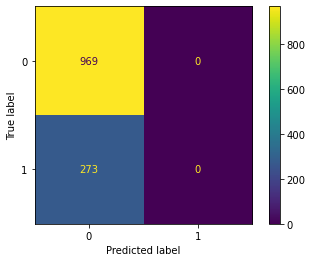

In [22]:
from sklearn.dummy import DummyClassifier
baseline_model = DummyClassifier()
baseline_model.fit(X_train_sc, y_train)
baseline_preds = baseline_model.predict(X_test_sc)
ConfusionMatrixDisplay.from_predictions(y_test, baseline_preds);

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, baseline_preds))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       969
           1       0.00      0.00      0.00       273

    accuracy                           0.78      1242
   macro avg       0.39      0.50      0.44      1242
weighted avg       0.61      0.78      0.68      1242



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [24]:
logreg =LogisticRegression()


parameters = [{'penalty':['none','l2']}, 
              {'C':[1, 10, 100]}]

logreg_gr = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

logreg_gr.fit(X_train_sc, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'penalty': ['none', 'l2']}, {'C': [1, 10, 100]}],
             scoring='accuracy')

In [25]:
preds= logreg_gr.predict(X_test_sc)

In [26]:
pd.DataFrame(logreg_gr.cv_results_).sort_values('rank_test_score').head(5)[['params','mean_test_score']]

params  mean_test_score
0  {'penalty': 'none'}         0.870977
3            {'C': 10}         0.870977
4           {'C': 100}         0.870977
1    {'penalty': 'l2'}         0.870577
2             {'C': 1}         0.870577

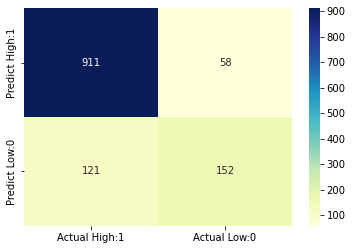

In [27]:
cm = confusion_matrix(y_test, preds)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       969
           1       0.72      0.56      0.63       273

    accuracy                           0.86      1242
   macro avg       0.80      0.75      0.77      1242
weighted avg       0.85      0.86      0.85      1242



In [29]:
logreg =LogisticRegression(random_state= 42, C= 10)
logreg.fit(X_train_sc, y_train)
preds= logreg.predict(X_test_sc)
pd.Series(logreg.coef_[0], index = X_train.columns).sort_values(ascending=False)

METASUM                     0.522454
ATTIMM                      0.411896
HOMEPOS                     0.409258
HISEI                       0.389071
GCAWARE                     0.302856
WORKMAST                    0.299509
GRADE                       0.240108
GCSELFEFF                   0.234880
Is_HISCED_5B_1              0.200040
PERSPECT                    0.181027
Is_FISCED_5B_1              0.140329
JOYREAD                     0.137782
ISCEDL_ISCED level 3        0.130687
IMMIG_Second-Generation     0.054000
DISCLIMA                    0.050257
AWACOM                      0.028711
EMOSUPS                     0.025983
IMMIG_Native                0.002854
BELONG                     -0.010554
ESCS                       -0.013491
TEACHINT                   -0.020860
RESPECT                    -0.043806
SCREADCOMP                 -0.053459
PISADIFF                   -0.071836
Is_MISCED_5B_1             -0.081588
GENDER_1                   -0.194400
RESILIENCE                 -0.194924
M

In [30]:
# coefficient dataframe
logreg_coef = pd.DataFrame(data=logreg.coef_,columns=X_train.columns).T.sort_values(by=0,ascending=False)

# Label the color the each coefficient
color = ['red' if x < 0 else 'blue' for x in logreg_coef[0]]

# Assign the color_list to new column
logreg_coef['color'] = color

logreg_coef.head()

0 color
METASUM  0.522454  blue
ATTIMM   0.411896  blue
HOMEPOS  0.409258  blue
HISEI    0.389071  blue
GCAWARE  0.302856  blue

In [31]:
# Select the highest values whether negative or positive
abs(logreg_coef[0]).sort_values(ascending=False)[:10].index

Index(['SCREADDIFF', 'DISCRIM', 'METASUM', 'REPEAT_Repeated a  grade',
       'ATTIMM', 'HOMEPOS', 'HISEI', 'GCAWARE', 'WORKMAST', 'MASTGOAL'],
      dtype='object')

Text(0.5, 1.0, 'Top 10 highest coefficient')

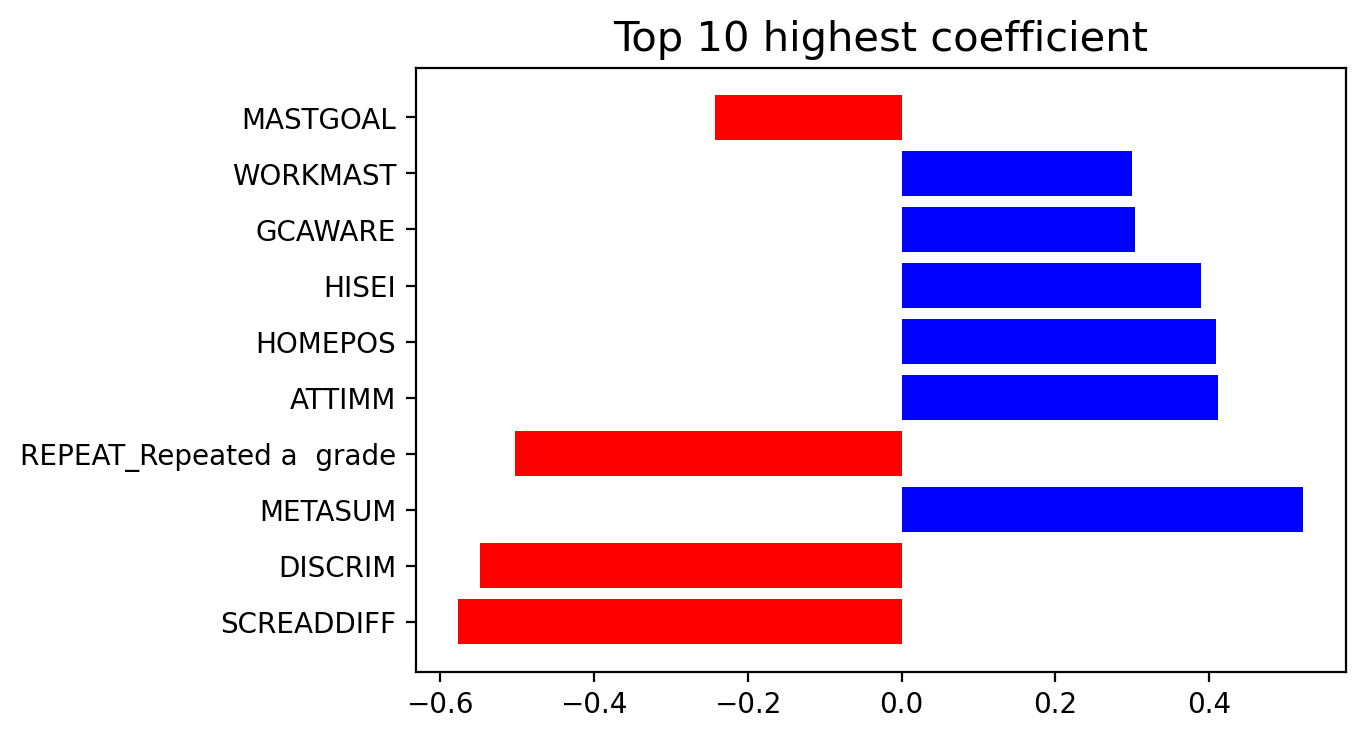

In [33]:
# Plot the coefficient of top 10 highest coefficient 
plt.figure(dpi=200)
plt.barh(logreg_coef.loc[['SCREADDIFF', 'DISCRIM', 'METASUM', 'REPEAT_Repeated a  grade',
       'ATTIMM', 'HOMEPOS', 'HISEI', 'GCAWARE', 'WORKMAST', 'MASTGOAL']].index,logreg_coef.loc[['SCREADDIFF', 'DISCRIM', 'METASUM', 'REPEAT_Repeated a  grade',
       'ATTIMM', 'HOMEPOS', 'HISEI', 'GCAWARE', 'WORKMAST', 'MASTGOAL']][0],color=logreg_coef.loc[['SCREADDIFF', 'DISCRIM', 'METASUM', 'REPEAT_Repeated a  grade',
       'ATTIMM', 'HOMEPOS', 'HISEI', 'GCAWARE', 'WORKMAST', 'MASTGOAL']]['color'])
plt.title('Top 10 highest coefficient',size=15)

In [34]:
ebm = ExplainableBoostingClassifier(random_state=42, feature_names =X_train.columns)
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(feature_names=['GRADE', 'HISEI', 'ESCS',
                                             'METASUM', 'HOMEPOS', 'DISCLIMA',
                                             'EMOSUPS', 'TEACHINT', 'JOYREAD',
                                             'SCREADCOMP', 'SCREADDIFF',
                                             'PISADIFF', 'WORKMAST',
                                             'RESILIENCE', 'MASTGOAL',
                                             'GCSELFEFF', 'GCAWARE', 'ATTIMM',
                                             'PERSPECT', 'RESPECT', 'AWACOM',
                                             'DISCRIM', 'BELONG',
                                             'Is_MISCED_5B_1', 'Is_FISCED_5B_1',
                                             'Is_HISCED_5B_1',
                                             'ISCEDL_ISCED leve...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                                             'categorical', 'categorical', ...])

In [35]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)


In [36]:
ebm.score(X_train, y_train),ebm.score(X_test, y_test)

(0.9097819563912782, 0.8711755233494364)

In [37]:
preds_ebm = ebm.predict(X_test)

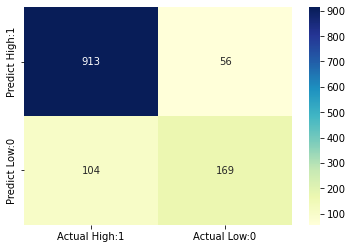

In [38]:
cm_ebm = confusion_matrix(y_test, preds_ebm)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_ebm, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [39]:
print(classification_report(y_test, preds_ebm))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       969
           1       0.75      0.62      0.68       273

    accuracy                           0.87      1242
   macro avg       0.82      0.78      0.80      1242
weighted avg       0.87      0.87      0.87      1242



In [40]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
param_test = {'learning_rate': [0.001,0.005,0.01,0.03],
              'interactions': [5,10,15],
              'max_interaction_bins': [10,15,20],
              'max_rounds': [5000,10000,15000,20000],
              'min_samples_leaf': [2,3,5],
              'max_leaves': [3,5,10]}
n_HP_points_to_test=10
ebm_clf =ExplainableBoostingClassifier(random_state=42, feature_names =X_train.columns, n_jobs=-1)
ebm_gs = RandomizedSearchCV(
    estimator=ebm_clf,
    param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring="roc_auc",
    cv=3,
    refit=True,
    random_state=314,
    verbose=False,
)


In [41]:
ebm_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=ExplainableBoostingClassifier(feature_names=Index(['GRADE', 'HISEI', 'ESCS', 'METASUM', 'HOMEPOS', 'DISCLIMA', 'EMOSUPS',
       'TEACHINT', 'JOYREAD', 'SCREADCOMP', 'SCREADDIFF', 'PISADIFF',
       'WORKMAST', 'RESILIENCE', 'MASTGOAL', 'GCSELFEFF', 'GCAWARE', 'ATTIMM',
       'PERSPECT', 'RESPECT', 'AWACOM', 'DISCRIM', 'BELONG', 'Is_MISCED_5B_1',
       'Is_FISCED_...
       'IMMIG_Native', 'IMMIG_Second-Generation', 'REPEAT_Repeated a  grade',
       'GENDER_1'],
      dtype='object'),
                                                           n_jobs=-1),
                   param_distributions={'interactions': [5, 10, 15],
                                        'learning_rate': [0.001, 0.005, 0.01,
                                                          0.03],
                                        'max_interaction_bins': [10, 15, 20],
                                        'max_leaves': [3, 5, 10],
                                        'max_rounds': [5000, 10000, 15000,
                                                       20000],
                                        'min_samples_leaf': [2, 3, 5]},
                   random_state=314, scoring='roc_auc', verbose=False)

In [42]:
#y_train = le.fit_transform(y_train)
#y_test = le.fit_transform(y_test)

In [43]:
ebm_gs.best_params_

{'min_samples_leaf': 3,
 'max_rounds': 15000,
 'max_leaves': 10,
 'max_interaction_bins': 15,
 'learning_rate': 0.001,
 'interactions': 15}

In [44]:
preds_ebm_gs = ebm_gs.predict(X_test)

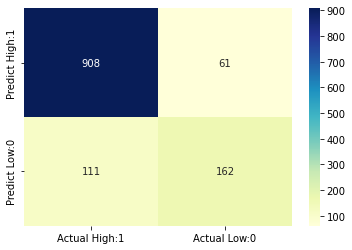

In [45]:
cm_ebm_gs = confusion_matrix(y_test, preds_ebm_gs)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_ebm_gs, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [46]:
print(classification_report(y_test, preds_ebm_gs))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       969
           1       0.73      0.59      0.65       273

    accuracy                           0.86      1242
   macro avg       0.81      0.77      0.78      1242
weighted avg       0.85      0.86      0.86      1242



In [47]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training set

rfc.fit(X_train, y_train)

# Predict on the test set results

preds_rfc = rfc.predict(X_test)
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. 
      format(accuracy_score(y_test, preds)))

Model accuracy score with 100 decision-trees : 0.8559


In [48]:
#Find important features with Random Forest model 

In [49]:
# view the feature scores

feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

SCREADDIFF                  0.090363
HOMEPOS                     0.074647
DISCRIM                     0.073264
HISEI                       0.072089
ESCS                        0.063881
ATTIMM                      0.050949
GCAWARE                     0.050782
JOYREAD                     0.050479
WORKMAST                    0.048113
GCSELFEFF                   0.044510
PISADIFF                    0.038732
METASUM                     0.037176
BELONG                      0.032341
PERSPECT                    0.031122
AWACOM                      0.029901
DISCLIMA                    0.028172
RESILIENCE                  0.026217
MASTGOAL                    0.023777
SCREADCOMP                  0.022768
TEACHINT                    0.022564
RESPECT                     0.018185
EMOSUPS                     0.016506
GRADE                       0.011926
Is_FISCED_5B_1              0.011111
Is_HISCED_5B_1              0.010987
GENDER_1                    0.006777
Is_MISCED_5B_1              0.006375
R

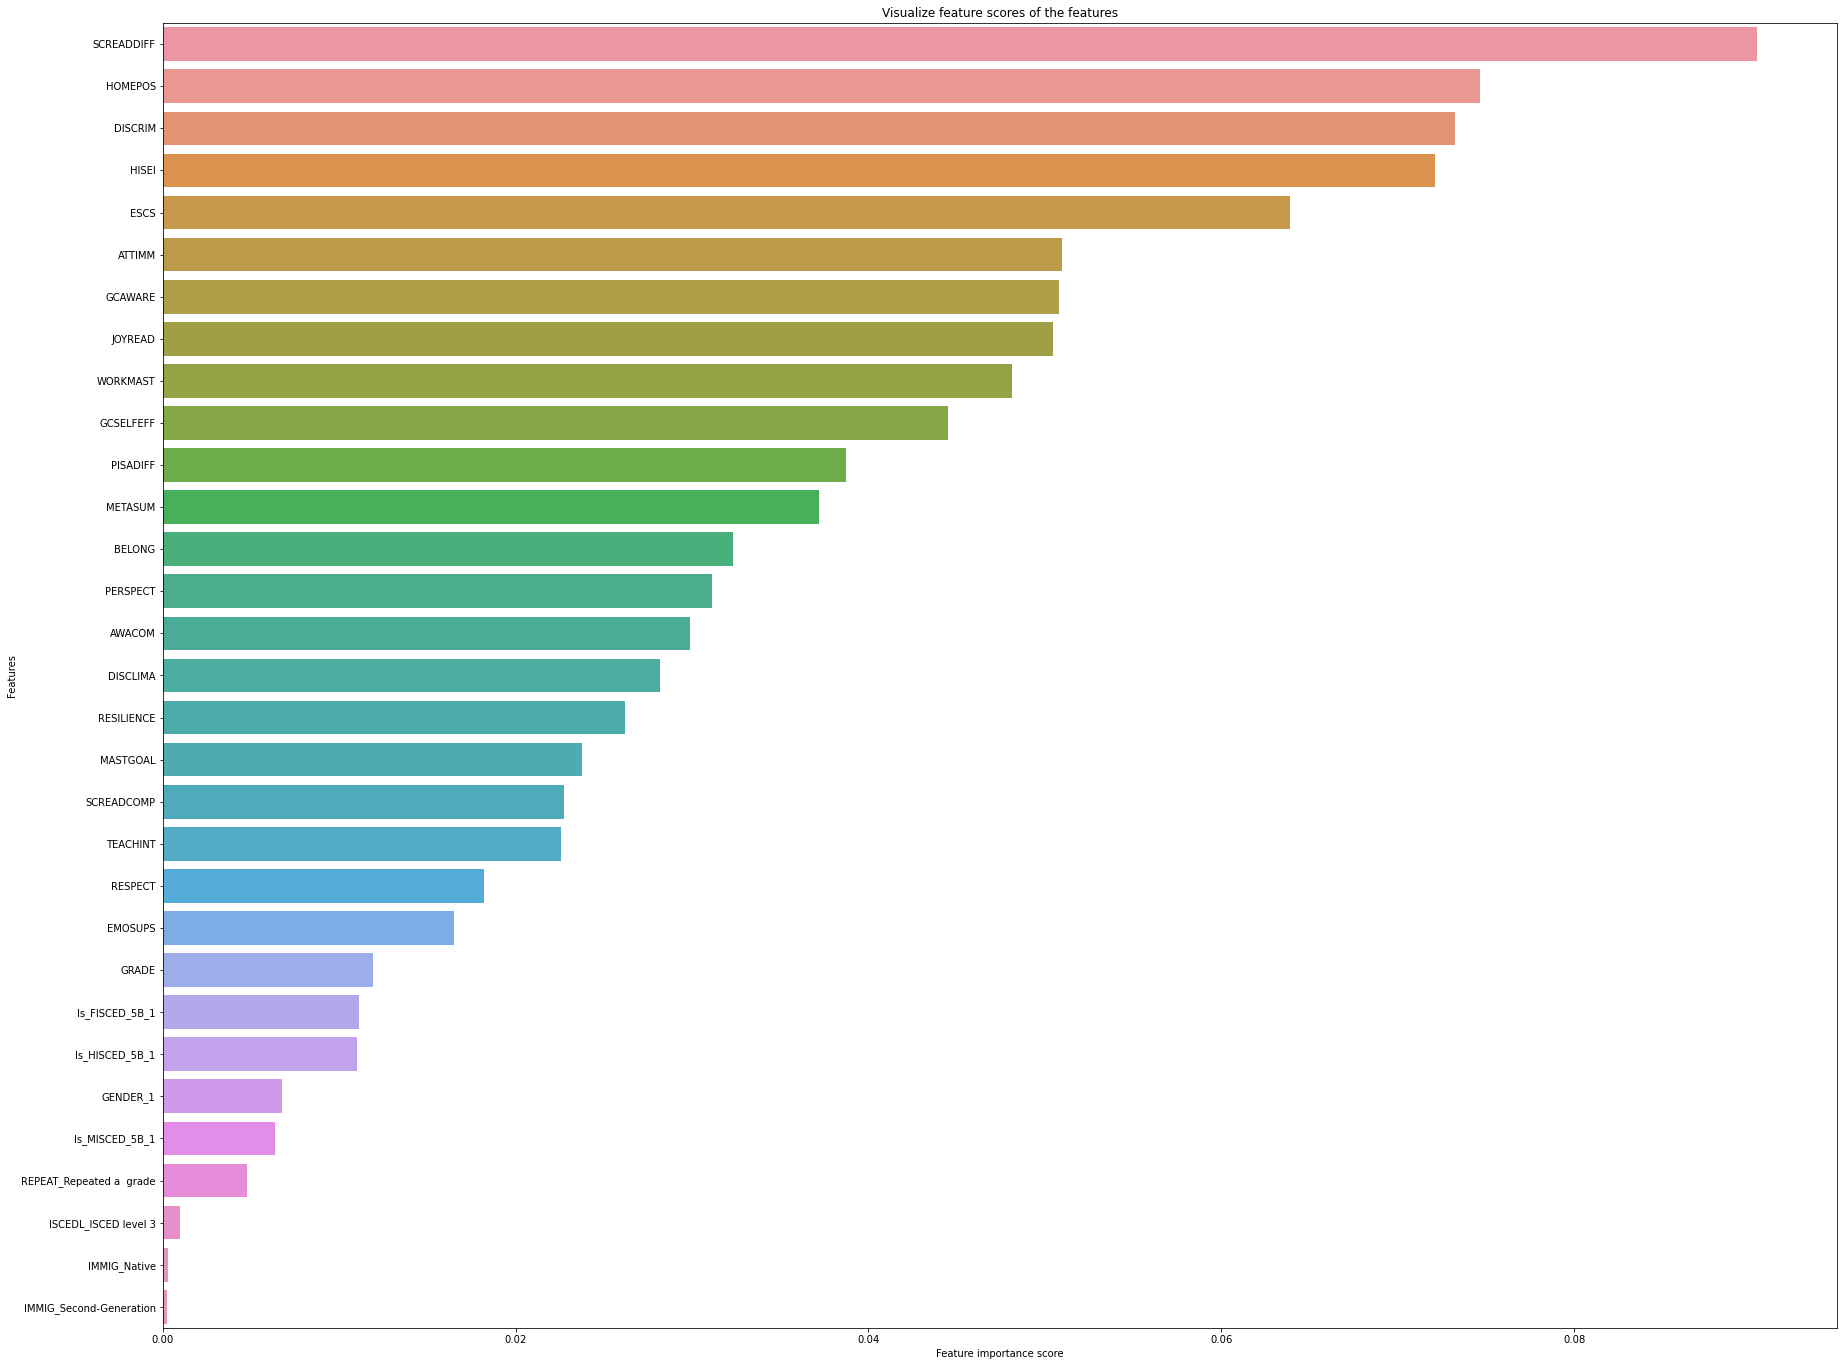

In [50]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=train_philippines)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

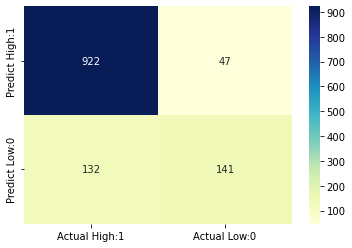

In [51]:
cm_rfc = confusion_matrix(y_test, preds_rfc)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_rfc, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [52]:
print(classification_report(y_test, preds_rfc))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       969
           1       0.75      0.52      0.61       273

    accuracy                           0.86      1242
   macro avg       0.81      0.73      0.76      1242
weighted avg       0.85      0.86      0.85      1242



In [53]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [54]:
xgb = XGBClassifier(n_estimators = 200, learning_rate = 0.5, max_depth = 4)
xgb.fit(X_train_sc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [55]:
preds_xgb = xgb.predict(X_test_sc)

In [56]:
# view the feature scores

feature_scores = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

REPEAT_Repeated a  grade    0.152104
Is_HISCED_5B_1              0.090009
SCREADDIFF                  0.080794
ATTIMM                      0.073915
METASUM                     0.049968
Is_FISCED_5B_1              0.045073
WORKMAST                    0.044306
DISCRIM                     0.038542
HISEI                       0.034520
GCAWARE                     0.034478
HOMEPOS                     0.031105
GRADE                       0.028335
JOYREAD                     0.025203
MASTGOAL                    0.024581
ESCS                        0.022660
PISADIFF                    0.022105
AWACOM                      0.021330
SCREADCOMP                  0.020874
GCSELFEFF                   0.019656
GENDER_1                    0.018700
RESILIENCE                  0.018049
EMOSUPS                     0.017302
BELONG                      0.017218
PERSPECT                    0.016684
RESPECT                     0.015874
DISCLIMA                    0.014770
TEACHINT                    0.012774
I

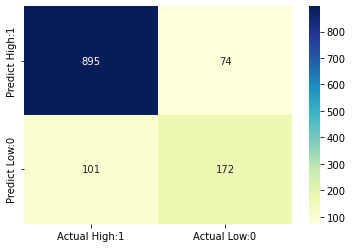

In [57]:
cm_xgb = confusion_matrix(y_test, preds_xgb)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_xgb, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [58]:
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       969
           1       0.70      0.63      0.66       273

    accuracy                           0.86      1242
   macro avg       0.80      0.78      0.79      1242
weighted avg       0.85      0.86      0.86      1242



In [59]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train_sc)

C:\Users\science01\Anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



In [60]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:],  pd.DataFrame(X_test, columns =X_test.columns).iloc[0,:])

In [61]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:],  pd.DataFrame(X_test, columns =X_test.columns).iloc[:1000,:])

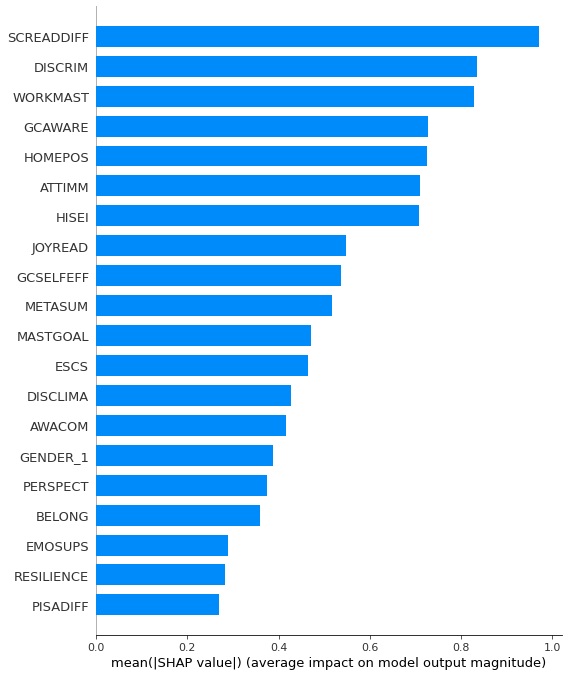

In [62]:
shap.summary_plot(shap_values, X_train_sc, plot_type="bar", feature_names= X_train.columns)

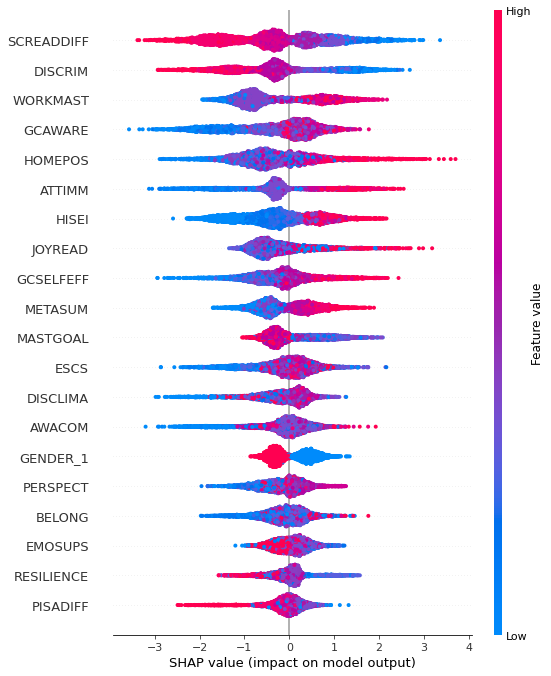

In [63]:
shap.summary_plot(shap_values, X_train)

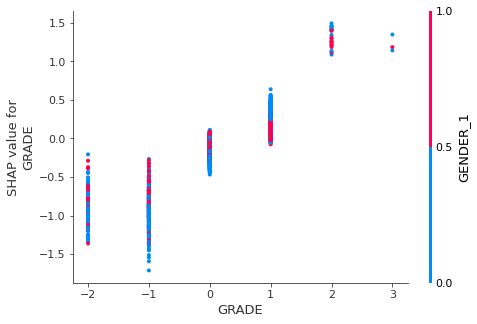

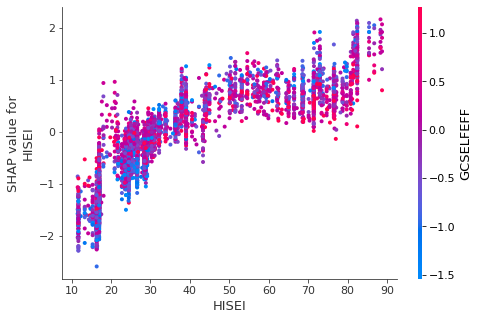

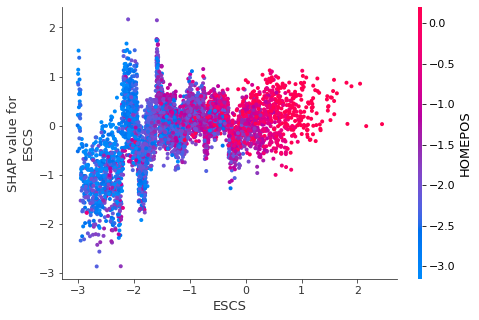

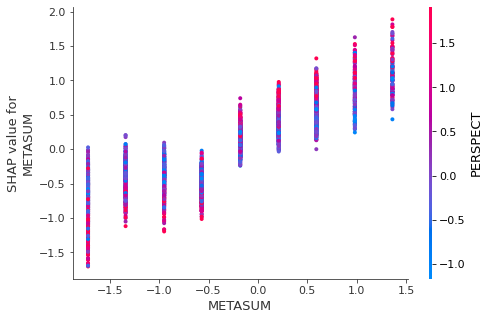

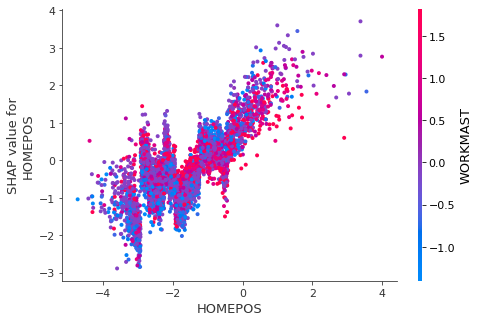

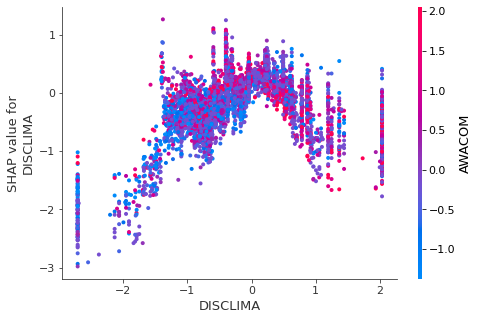

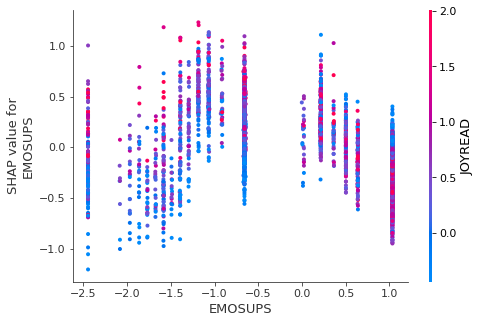

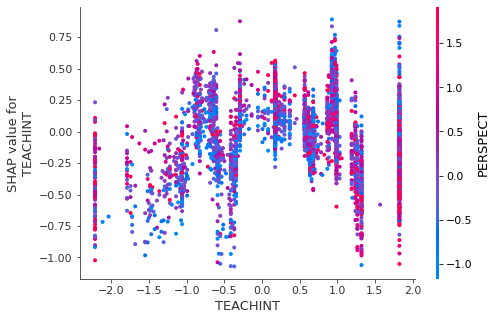

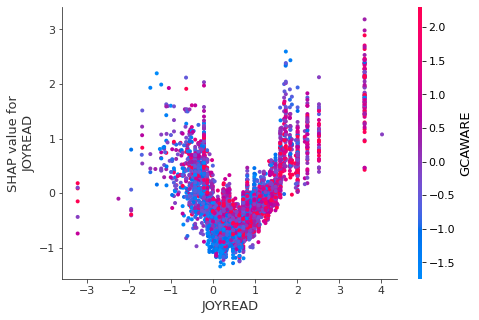

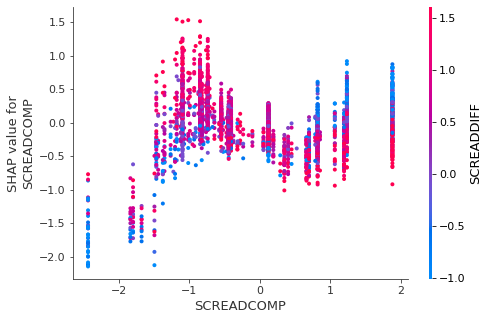

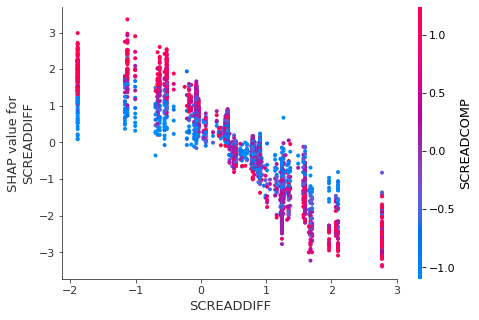

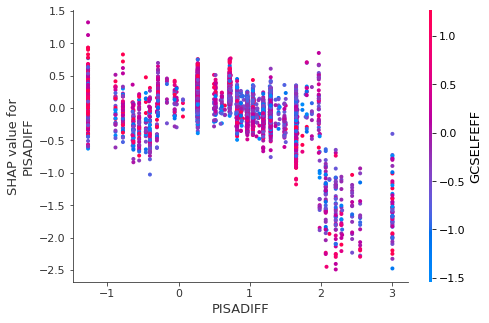

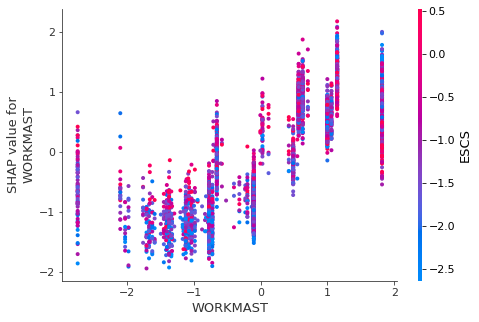

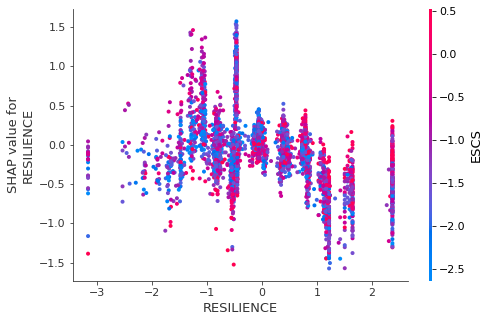

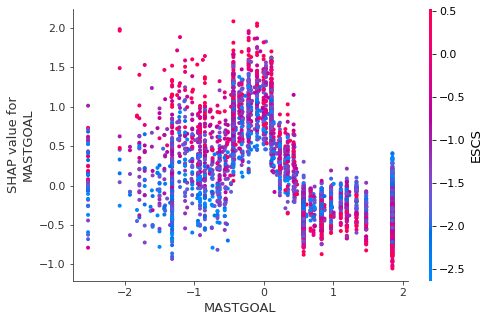

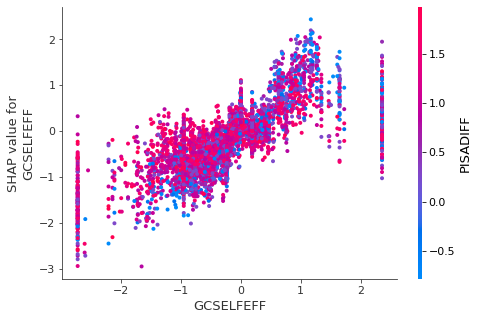

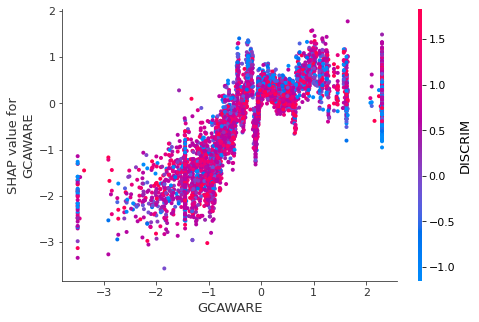

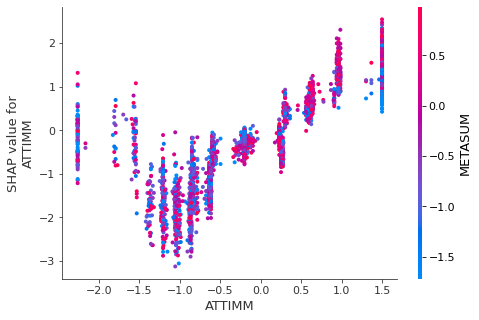

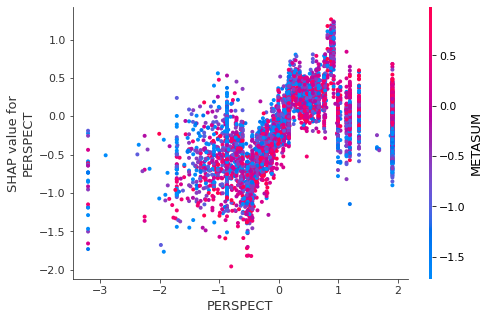

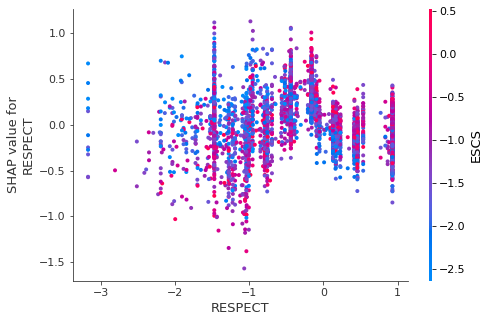

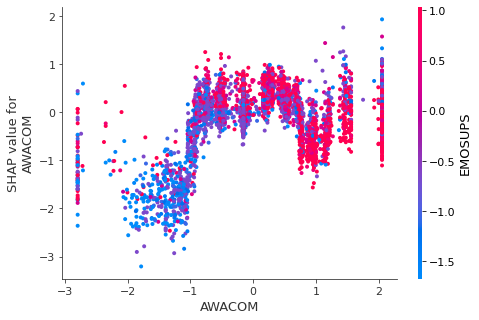

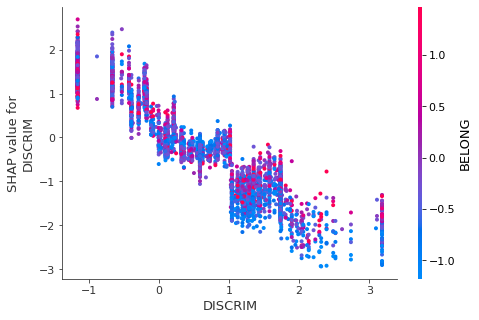

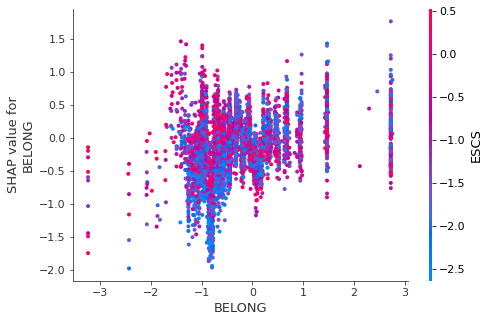

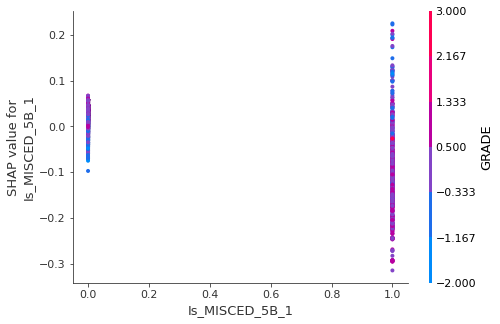

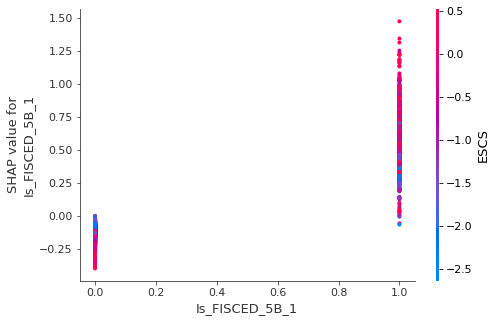

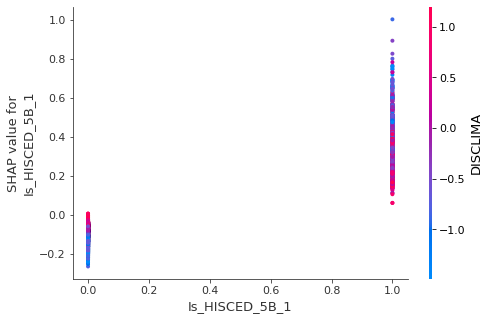

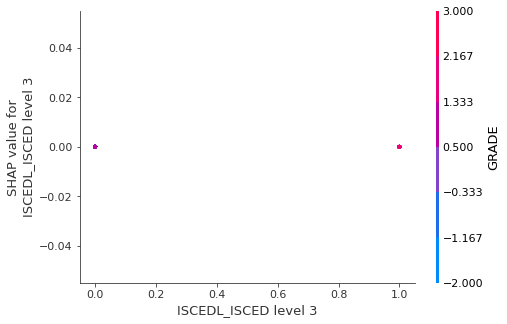

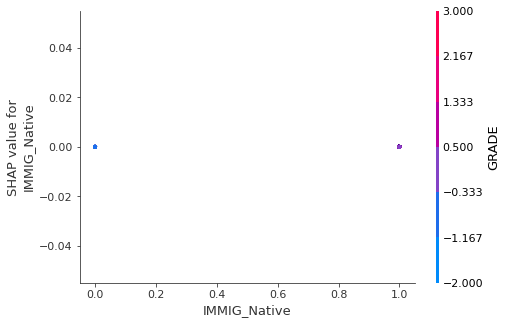

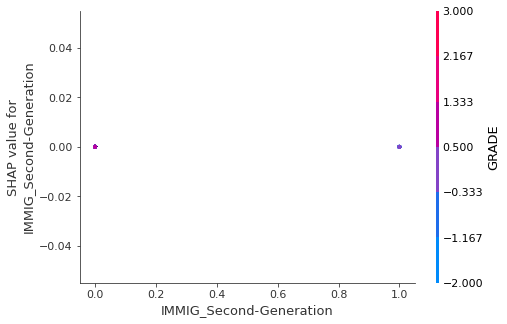

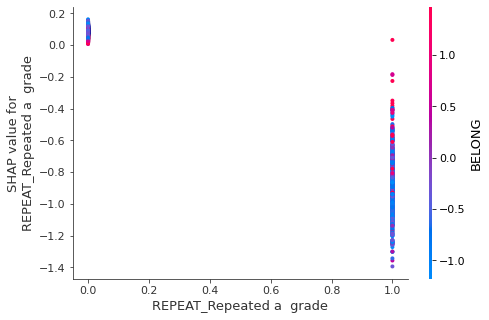

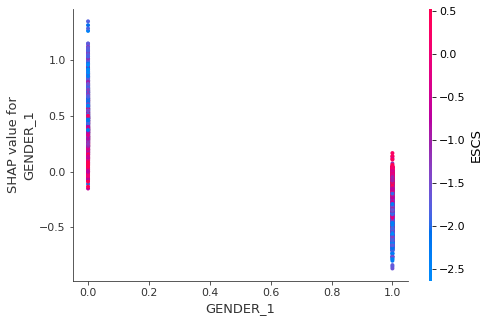

In [64]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)